# Fracking and Oklahoma Quakes analysis

In this analysis, I will be looking at the dataset [Oklahoma Earthquakes and Saltwater Injection Wells](https://www.kaggle.com/ksuchris2000/oklahoma-earthquakes-and-saltwater-injection-wells) to see if I can find any correlation between the earthquakes and the use of [Injection Wells](https://en.wikipedia.org/wiki/Injection_well)

### Preface

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import cartopy
from cartopy import crs

http://www.ogs.ou.edu/pubsscanned/openfile/OF1_2014_Murray.pdf

### Preprocessing

Source: https://www.kaggle.com/ksuchris2000/oklahoma-earthquakes-and-saltwater-injection-wells


In [2]:
wells_data = pd.read_csv('data_fracking/InjectionWells.csv')

wells_data = wells_data.drop(columns=[
    'Operator ID', 'WellNumber', 'OrderNumbers', 'Sec', 'Twp', 'Rng', 'QQQQ',
    'ZONE', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'API#'
])

# Drop outlier datapoints
wells_data = wells_data[wells_data['LONG'] < -95]
wells_data = wells_data[wells_data['LONG'] > -105]

wells_data['Approval Date'] = pd.to_datetime(wells_data['Approval Date'])
wells_data = wells_data.sort_values('Approval Date').reset_index().drop(columns=['index'])

def convert_to_float(x):
    try:
        return float(x)
    except Exception:
        return float('nan')

wells_data['BBLS'] = wells_data['BBLS'].apply(str).str.replace(',', '').apply(
    lambda x: convert_to_float(x)
)
wells_data['PSI'] = wells_data['PSI'].apply(str).str.replace(',', '').apply(
    lambda x: convert_to_float(x)
)

wells_data

,Operator,WellType,WellName,Approval Date,County,LAT,LONG,PSI,BBLS
0,XTO ENERGY INC,2R,HEWITT UNIT 22,1936-12-18,CARTER,34.199067,-97.399092,1100.0,3500.0
1,GATEWAY RESOURCES USA INC,2R,ANDY BROWN,1945-04-22,WASHINGTON,36.901903,-95.900888,NaN,NaN
2,WHITE MONTY & TERRY PRODUCTION,2D,"ROLLER, B. H.",1946-10-19,LINCOLN,35.511472,-96.767417,0.0,100.0
3,CIRCLE 9 RESOURCES LLC,2R,SCHOOL LAND 66,1947-03-18,PAWNEE,36.164978,-96.717249,NaN,NaN
4,CIRCLE 9 RESOURCES LLC,2R,SCHOOL LAND 66,1947-03-18,PAWNEE,36.167568,-96.722799,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11056,CITATION OIL & GAS CORPORATION,2R,COX PENN SAND UNIT,2017-08-30,CARTER,34.373645,-97.399878,1500.0,999.0
11057,COMPLETE ENERGY SERVICES INC,CDW,SEILING SWD,2017-08-30,DEWEY,36.146649,-98.934932,1635.0,5000.0
11058,URBAN OIL & GAS GROUP LLC,2R,GLADYS LOVE,2017-08-30,MCCLAIN,34.919795,-97.421550,3500.0,500.0
11059,BROWER OIL & GAS CO INC,2D,REED,2017-08-30,OKMULGEE,35.475614,-95.911700,400.0,500.0


In [3]:
quakes_data = pd.read_csv('data_fracking/okQuakes.csv')
quakes_data = quakes_data[quakes_data['type'] == 'earthquake']
quakes_data['time'] = pd.to_datetime(quakes_data['time'])
quakes_data = quakes_data.sort_values(by='time')
quakes_data.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1973-03-17 07:43:05.500000+00:00,36.087,-106.168,6.0,4.5,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:10.078Z,New Mexico,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
1,1973-05-25 14:40:13.900000+00:00,33.917,-90.775,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:12.859Z,Mississippi,earthquake,NaN,NaN,NaN,NaN,reviewed,s,us
2,1973-09-19 13:28:20.500000+00:00,37.160,-104.594,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:20.295Z,Colorado,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
3,1973-09-23 03:58:54.900000+00:00,37.148,-104.571,5.0,4.2,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:20.346Z,Colorado,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
4,1974-02-15 13:33:49.200000+00:00,36.500,-100.693,24.0,4.5,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:21:22.859Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


## Mapping

<ipython-input-4-68244984123a>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


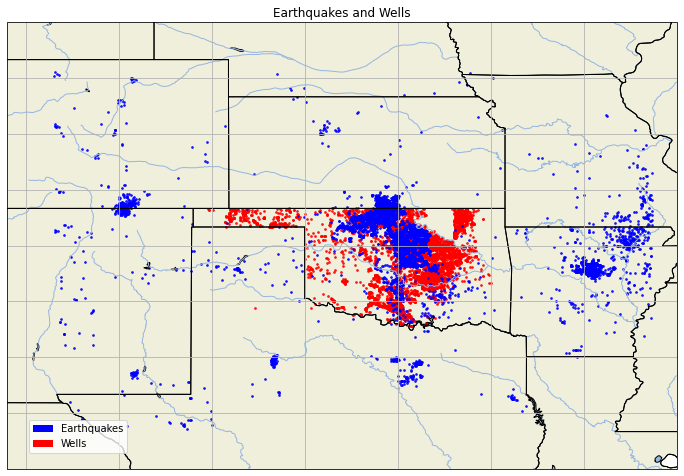

In [4]:
def draw_map(
    extent=[-108, -90, 42, 30],  # x1, x2, y1, y2
    min_magnitude=0,             # min earthquake magnitude
    max_magnitude=20,            # max earthquake magnitude
    min_bbls=0,
    max_bbls=None,
):
    fig = plt.figure(figsize=(12,10))

    ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

    ax.set_title('Earthquakes and Wells')
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.STATES)
    ax.gridlines(draw_labels=True, crs=crs.PlateCarree())

    cutoff_quakes = quakes_data[quakes_data['mag'] > min_magnitude]
    cutoff_quakes = cutoff_quakes[cutoff_quakes['mag'] < max_magnitude]

    cutoff_wells = wells_data[wells_data['BBLS'] > min_bbls]
    if max_bbls:
        cutoff_wells = cutoff_wells[cutoff_wells['BBLS'] < max_bbls]

    ax.scatter(
        x=cutoff_wells['LONG'], y=cutoff_wells['LAT'],
        color="red",
        alpha=0.8,
        s=3,
        transform=crs.PlateCarree()
    )
    ax.scatter(
        x=cutoff_quakes['longitude'], y=cutoff_quakes['latitude'],
        color='blue',
        alpha=0.8,
        s=3,
        transform=crs.PlateCarree()
    )

    quakes_label = mpatches.Rectangle((1,1), 1, 1, facecolor='blue')
    wells_label = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")

    labels = ['Earthquakes', 'Wells']

    ax.legend(
        [quakes_label, wells_label],
        labels,
        loc='lower left',
        bbox_to_anchor=(0.025, 0.025),
        fancybox=True
    )

    fig.show()

draw_map()

<ipython-input-4-68244984123a>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


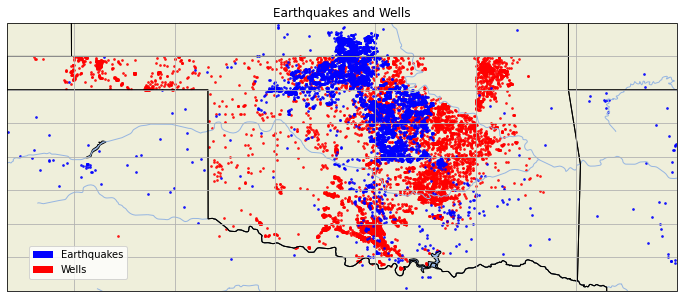

In [5]:
draw_map([-103, -93, 37.5, 33.5])

<ipython-input-4-68244984123a>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


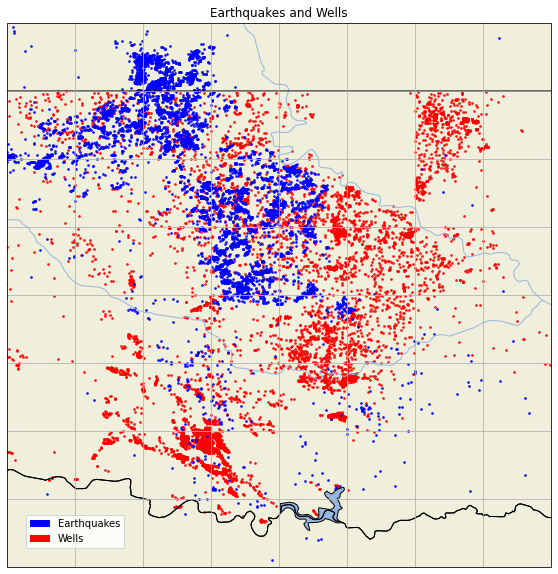

In [6]:
draw_map([-99, -95, 37.5, 33.5], max_magnitude=7)

<ipython-input-7-c274392ba887>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


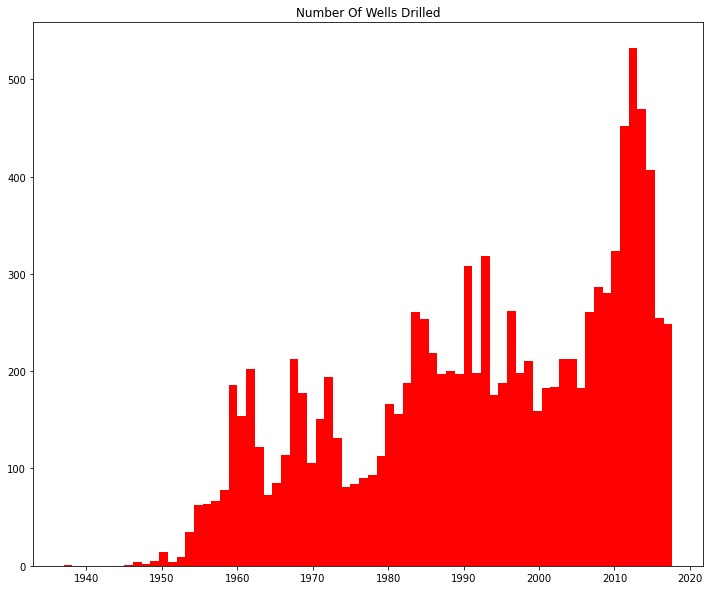

In [7]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()
ax.set_title('Number Of Wells Drilled')
ax.hist(wells_data['Approval Date'], bins=70, color='red')
fig.show()

<ipython-input-8-babbf58961a6>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


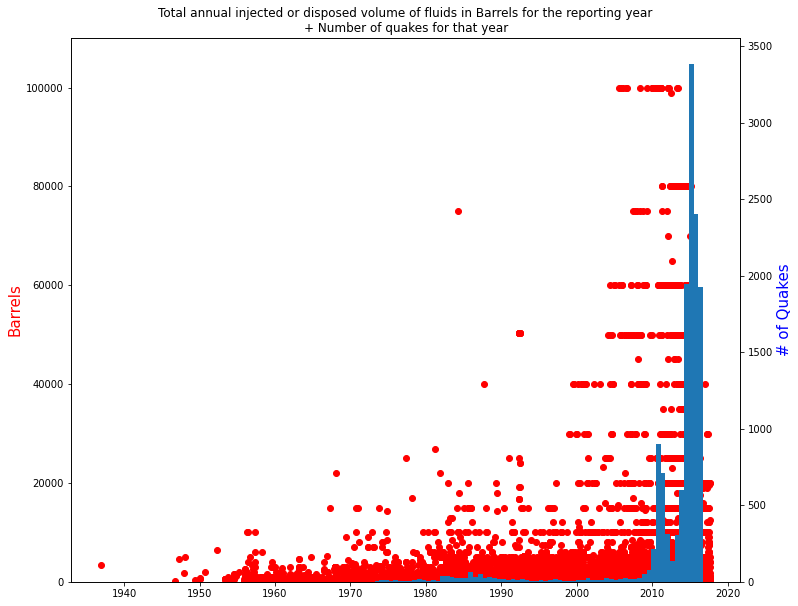

In [8]:
cleaned = wells_data.dropna()

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()
ax.set_title('Total annual injected or disposed volume of fluids in Barrels for the reporting year\n+ Number of quakes for that year')
ax.scatter(x=cleaned['Approval Date'], y=cleaned['BBLS'], color='red')
ax.margins(y=0)
ax.set_ylim([0, 110_000])
ax.set_ylabel('Barrels', color='red', size=15)
ax2 = ax.twinx()
ax2.hist(quakes_data['time'], bins=70)
ax2.set_ylabel('# of Quakes', color='blue', size=15)
fig.show()